In [75]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import random_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries

import warnings
warnings.filterwarnings("ignore")

In [76]:
data = pd.read_csv('h2_n2_data.csv', parse_dates=['timestamp'], index_col='timestamp')
data = data['2023-07-18 00:0:00':'2023-08-18 00:0:00']
data = data.asfreq('5min')

In [77]:
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
data = data.fillna(data.mean())

Number of rows with missing values: 0.0017919139881285699


In [78]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


Train dates : 2023-07-18 00:00:00 --- 2023-08-14 12:40:00  (n=7929)
Test dates  : 2023-08-14 12:45:00 --- 2023-08-18 00:00:00  (n=1000)


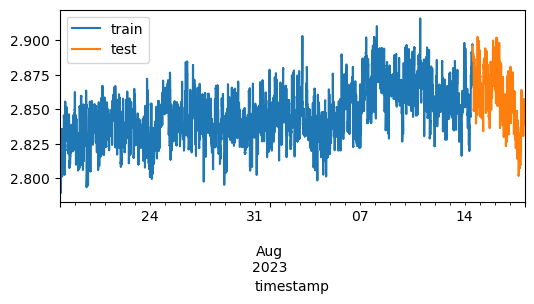

In [79]:
# Split data into train-test
# ==============================================================================
steps = 1000
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['ground_truth_H2_N2_ratio'].plot(ax=ax, label='train')
data_test['ground_truth_H2_N2_ratio'].plot(ax=ax, label='test')
ax.legend();

In [185]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor       = Ridge(alpha=1.0e-06),
                 #regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 level           = 'ground_truth_H2_N2_ratio',
                 steps           = 12,
                 lags            = 6,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[12]),
                 n_jobs          = 'auto'
             )

forecaster.fit(series=data_train)
forecaster

============================ 
ForecasterDirectMultiVariate 
============================ 
Regressor: Ridge 
Target series (level): ground_truth_H2_N2_ratio 
Lags: [1 2 3 4 5 6] 
Window features: ['roll_mean_12'] 
Window size: 12 
Maximum steps to predict: 12 
Multivariate series: 
    HIC03062, HIC03044, AI03142, AI94011A, AI94011C, AI94011D, AI94011E,
    ground_truth_H2_N2_ratio 
Exogenous included: False 
Exogenous names: None 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2023-07-18 00:00:00'), Timestamp('2023-08-14 12:40:00')] 
Training index type: DatetimeIndex 
Training index frequency: 5min 
Regressor parameters: 
    {'alpha': 1e-06, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-12-19 08:55:24 
Last fit date: 2024-12-19 08:55:24 
Skforecast version: 0.14.0 
Python version: 3.9.20 
Forecaster id: None

In [186]:
forecaster.predict(steps=None)

,ground_truth_H2_N2_ratio
2023-08-14 12:45:00,2.894209
2023-08-14 12:50:00,2.887032
2023-08-14 12:55:00,2.881793
2023-08-14 13:00:00,2.879765
2023-08-14 13:05:00,2.878285
2023-08-14 13:10:00,2.878721
2023-08-14 13:15:00,2.879249
2023-08-14 13:20:00,2.878850
2023-08-14 13:25:00,2.877687
2023-08-14 13:30:00,2.876014


In [187]:
forecaster.get_feature_importances(step=2)

,feature,importance
49,ground_truth_H2_N2_ratio_lag_1,1.078295
54,ground_truth_H2_N2_ratio_lag_6,0.386614
11,HIC03044_lag_5,0.282842
6,HIC03062_roll_mean_12,0.233062
0,HIC03062_lag_1,0.212653
8,HIC03044_lag_2,0.206720
41,AI94011D_roll_mean_12,0.162782
5,HIC03062_lag_6,0.127925
51,ground_truth_H2_N2_ratio_lag_3,0.124864
30,AI94011C_lag_3,0.119241


In [188]:
# Predict with forecaster MultiVariate
# ==============================================================================
predictions = forecaster.predict(steps=None)  # All steps
predictions

,ground_truth_H2_N2_ratio
2023-08-14 12:45:00,2.894209
2023-08-14 12:50:00,2.887032
2023-08-14 12:55:00,2.881793
2023-08-14 13:00:00,2.879765
2023-08-14 13:05:00,2.878285
2023-08-14 13:10:00,2.878721
2023-08-14 13:15:00,2.879249
2023-08-14 13:20:00,2.878850
2023-08-14 13:25:00,2.877687
2023-08-14 13:30:00,2.876014


In [189]:
# Backtesting MultiVariate
# ==============================================================================
cv = TimeSeriesFold(
         steps                 = 6,
         initial_train_size    = len(data_train),
         refit                 = False,
         allow_incomplete_fold = True
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster    = forecaster,
                                           series        = data,
                                           cv            = cv,
                                           metric        = 'mean_squared_error',
                                           n_jobs        = 'auto',
                                           verbose       = False,
                                           show_progress = True
                                       )
print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 64.84it/s]

Backtest metrics


,levels,mean_squared_error
0,ground_truth_H2_N2_ratio,0.000151



Backtest predictions


,ground_truth_H2_N2_ratio
2023-08-14 12:45:00,2.894209
2023-08-14 12:50:00,2.887032
2023-08-14 12:55:00,2.881793
2023-08-14 13:00:00,2.879765


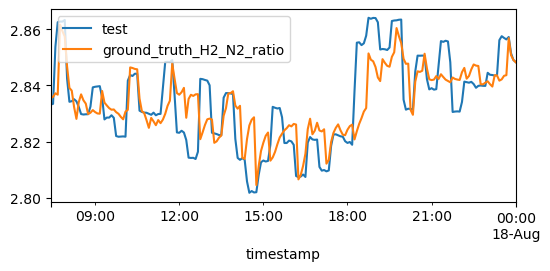

In [190]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
#data_train['ground_truth_H2_N2_ratio'].plot(ax=ax, label='train')
data['ground_truth_H2_N2_ratio'].iloc[-200:].plot(ax=ax, label='test')
backtest_predictions.iloc[-200:].plot(ax=ax, label='predictions')
ax.legend();

In [191]:
from sklearn.metrics import r2_score
actual_vals = data.loc[backtest_predictions.index, 'ground_truth_H2_N2_ratio'].to_numpy()
predicted_vals = backtest_predictions.to_numpy()
r2 = r2_score(actual_vals, predicted_vals)
print("R-squared:", r2)

R-squared: 0.6690878149309418


In [96]:
# Random search MultiVariate
# ==============================================================================
lags_grid = [6,8,10,12]
param_distributions = {
    'alpha': [1.0e-01, 1.0e-02, 1.0e-04, 1.0e-06],
}

cv = TimeSeriesFold(
         steps                 = 6,
         initial_train_size    = len(data_train),
         refit                 = False,
         allow_incomplete_fold = True
     )

results = random_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              metric              = 'mean_squared_error',
              aggregate_metric    = 'weighted_average',
              n_iter              = 5,
              return_best         = False,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = False
          )

results

,levels,lags,lags_label,params,mean_squared_error,alpha
0,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1e-06},0.000144,0.000001
1,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001},0.000144,0.000100
2,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]",{'alpha': 0.0001},0.000145,0.000100
3,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]",{'alpha': 1e-06},0.000145,0.000001
4,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1e-06},0.000145,0.000001
5,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.0001},0.000145,0.000100
6,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",{'alpha': 1e-06},0.000145,0.000001
7,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",{'alpha': 0.0001},0.000145,0.000100
8,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",{'alpha': 0.01},0.000146,0.010000
9,[ground_truth_H2_N2_ratio],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.01},0.000147,0.010000
